In [1]:
import re
import helper
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

ODI_DATASET_PATH = './data/ODI-2022.csv'

In [2]:
# # load csv file to pandas dataframe to retrieve column names
# df_temp= pd.read_csv("./data/ODI-2022.csv", delimiter=";")
# df_temp

# Assignment 1

In [3]:
# Initialize 2 dimensional array
dataset = helper.get_data(ODI_DATASET_PATH)
# Initialize columns
columns = list(zip(*dataset))

# print("What programme are you in? = {}".format(columns[1]))
# print("Have you taken a course on machine learning? = {}".format(columns[2]))
# print("Have you taken a course on information retrieval?; = {}".format(columns[3]))
# # mu is yes, sigma is no
# print("Have you taken a course on statistics? = {}".format(columns[4]))
# print("Have you taken a course on databases? = {}".format(columns[5]))
# print("What is your gender? = {}".format(columns[6]))
# print("Chocolate makes you..... = {}".format(columns[7]))
# print("When is your birthday (date)? = {}".format(columns[8]))
# print("Number of neighbors sitting around you? = {}".format(columns[9]))
# print("Did you stand up? = {}".format(columns[10]))
# print("What is your stress level (0-100)? = {}".format(columns[11]))
# print("You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then? = {}".format(columns[12]))
# print("Give a random number = {}".format(columns[13]))
# print("Time you went to be Yesterday = {}".format(columns[14]))
# print("What makes a good day for you (1)?; = {}".format(columns[15]))
# print("What makes a good day for you (2)? = {}".format(columns[16]))



c:\Users\Konstantin\Documents\Masters\Data Mining\dmt-assignment-1\assignment_1\helper.py:5: ConversionWarning: Some errors were detected !
    Line #150 (got 13 columns instead of 17)
    Line #207 (got 18 columns instead of 17)
  array = np.genfromtxt(file_name, dtype=datatype, delimiter=";", invalid_raise=False, skip_header=True)


In [4]:
# load csv file to pandas dataframe to retrieve column names
df_temp= pd.read_csv("./data/ODI-2022.csv", delimiter=";")
column_names = df_temp.columns

# convert dataset to pandas dataframe using column names from df_temp
df = pd.DataFrame(dataset)
df.columns=column_names

df_temp = df_temp.drop(labels=148, axis=0)
df_temp = df_temp.drop(labels=205, axis=0)

## clean all column values
# remove unimportant columns
# df = df.drop("Tijdstempel", axis=1) # remove Tijdstempel column because it has no meaning
# df = df.drop("Did you stand up?", axis=1) # remove stand up column because it has no meaning
# df = df.drop("Number of neighbors sitting around you?", axis=1) # remove neighbours column because it has no meaning
# df = df.drop("Give a random number", axis=1) # remove random number column because it has no meaning

# # convert column values to boolean for yes/no questions
# df['Have you taken a course on machine learning?'] = df['Have you taken a course on machine learning?'].replace(['yes','no','unknown'],[True,False,False])
# df['Have you taken a course on information retrieval?'] = df['Have you taken a course on information retrieval?'].replace([1,0,-1],[True,False, False])
# df['Have you taken a course on statistics?'] = df['Have you taken a course on statistics?'].replace(['mu','sigma', 'unknown'],[True,False,False])
# df['Have you taken a course on databases?'] = df['Have you taken a course on databases?'].replace(['ja','nee', 'unknown'],[True,False,False])

# # only keep years in birthday column
# def get_year(date):
#     year = re.search('[0-9]{4}', date)
#     symbols = {'/', '.', '-'}
#     if year == None:
#         if len(date) > 4 and any(sym in date for sym in symbols):
#             year = "19" + date[-2:]
#             if year.isdecimal():
#                 year = int(year)
#                 if 1930 > year:
#                     return np.nan
#                 elif year > 2005:
#                     return np.nan
#                 else:
#                     return year
#             else:
#                 return np.nan
#         else:
#             return np.nan
#     else:
#         year = int(year.group(0))
#         if 1930 > year:
#             return np.nan
#         elif year > 2005:
#             return np.nan
#         else:
#             return year

# # iterate all rows of birthday column and set all birthdays to year
# for index, row in df.iterrows():
#     birthday = (row["When is your birthday (date)?"])
#     new_birthday = get_year(birthday)
#     df['When is your birthday (date)?'] = df['When is your birthday (date)?'].replace([birthday],new_birthday)

# # clean stress level column --> set all values < 0 to 0 and > 100 to 100
# df = df.astype({'What is your stress level (0-100)?': int}, errors='raise')
# df['What is your stress level (0-100)?'].values[df['What is your stress level (0-100)?'].values > 100] = 100
# df['What is your stress level (0-100)?'].values[df['What is your stress level (0-100)?'].values < 0] = 0

# # clean competition column --> set all values < 0 to 0 and > 100 to 100
# df.rename(columns = {'You can get 100 euros if you win a local DM competition, or we don’t hold any competitions and I give everyone some money (not the same amount!). How much do you think you would deserve then? ':'competition'}, inplace = True)
# df = df.astype({'competition': int}, errors='raise')
# df['competition'].values[df['competition'].values > 100] = 100
# df['competition'].values[df['competition'].values < 0] = 0

# # clean bedtime column
# df.rename(columns={'Time you went to be Yesterday': 'bedtime'}, inplace=True)

# def clean_time(old):
#     old = old.lower()
#     if re.match('^[0-9]{2}\:[0-9]{2}$', old):
#         return old
#     elif re.match('^[0-9{2}\.[0-9]{2}$', old):
#         return old[0:2]
#     elif re.match('^[0-9]{2}$', old):
#         keep = {'9', '10', '11', '12', '21', '22', '23', '24'}
#         if old in keep:
#             new = old + ':' + '00'
#             return new
#         else:
#             return np.nan
#     elif len(old) == 1:
#         return np.nan
#     elif re.match('^[0-9]{4}$', old):
#         return old[0:2] + ':' + old[2:4]
#     elif old[-2:] == 'am':
#         digits = re.sub('[^0-9]', '', old)
#         if len(digits) == 4:
#             return digits[0:2] + ':' + digits[2:4]
#         elif len(digits) == 3:
#             return '0' + digits[0] + ':' + digits[1:3]
#         elif len(digits) == 2:
#             print("Fail!")
#             print(digits)
#         else:
#             return '0' + digits + ':00'
#     else:
#         print("Fail", old)
#     # if ':' in old:
#     #     old = old.replace(':', '')
#     #     if old.isdigit():
#     #         return old
#     #     else:
#     #         print(old)
#     # else:
#     #     print(old)

# for index, row in df.iterrows():
#     old_time = (row['bedtime'])
#     new_time = clean_time(old_time)
    
    # df['bedtime'] = df['bedtime'].replace([old_time], new_time)



# What kinds of attributes are there
## Boolean, object, integer, float
# print(df['What is your gender?'].unique())
# print(df.dtypes)
# display(df)


# Ranges of values
# Distribution of values,
# relationships between attributes
# and so on.










Fail 12 hours

Fail banana


Fail to be?



Fail 4 years ago

Fail noon





Fail definitely 7


Fail ja


Fail yellow




Fail 23.30






Fail what?


Fail 01.30

Fail 1:34


Fail midnight

Fail huh

Fail yesterday






Fail today

Fail haha



Fail 10:00 pm



Fail 12.00

Fail yes

Fail n/a




Fail gym

Fail 2.00





Fail yes

Fail 11pm






Fail 01.00

Fail 4 o' clock

Fail 4:35



Fail 2:00


Fail wot


Fail 20.09









Fail 7 hours


Fail 12.15



Fail i do not know



Fail 11.30pm



Fail 10:21:39

Fail 4:20

Fail idk





Fail today










Fail dizzy miss lizzy was a terrible song to end help! with


Fail 1.00






Fail 20.30

Fail 01.30



Fail 2:30






Fail 7:00


Fail 23pm

Fail 4:15



Fail 0:00


Fail 01.00





Fail 00.20


Fail 0:15h



Fail 4.30

Fail 23.30


Fail!
12









Fail 23.45









Fail 22.30


Fail!
12




Fail 5:30






Fail 8 pm

Fail 2:00




Fail 0:00










Fail 12.30

Fail null



Fail 23.34

Fail to be or not to be?

Fail

,What programme are you in?,Have you taken a course on machine learning?,Have you taken a course on information retrieval?,Have you taken a course on statistics?,Have you taken a course on databases?,What is your gender?,Chocolate makes you.....,When is your birthday (date)?,What is your stress level (0-100)?,competition,bedtime,What makes a good day for you (1)?,What makes a good day for you (2)?
0,artificial intelligence,True,False,True,False,female,neither,1998.0,0,5,23:00,coffee,sun
1,big data,True,False,True,False,male,fat,2000.0,100,1,32,7777,8964
2,Computational Science,True,True,True,True,male,fat,1998.0,0,100,x,0,0
3,Bioinformatics and Systems Biology,True,False,False,False,male,neither,1997.0,20,100,14:00,good food,no stress
4,AI,True,True,True,True,male,fat,1997.0,2,100,07:20,Sunshine,Good Food
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,Ai,True,True,False,False,not willing to answer,fat,1956.0,30,99,5,Yes,No
298,E,True,True,True,True,male,slim,NaN,9,5,9,9,9
299,MSc Computational Science,False,False,True,False,male,I have no idea what you are talking about,1995.0,100,1,555,Good food,Sleep more than 6 hours
300,Artificial Intelligence,True,False,True,False,not willing to answer,neither,NaN,70,87,0,nice weather,good mood


Text(0.5, 0, 'Frequency')

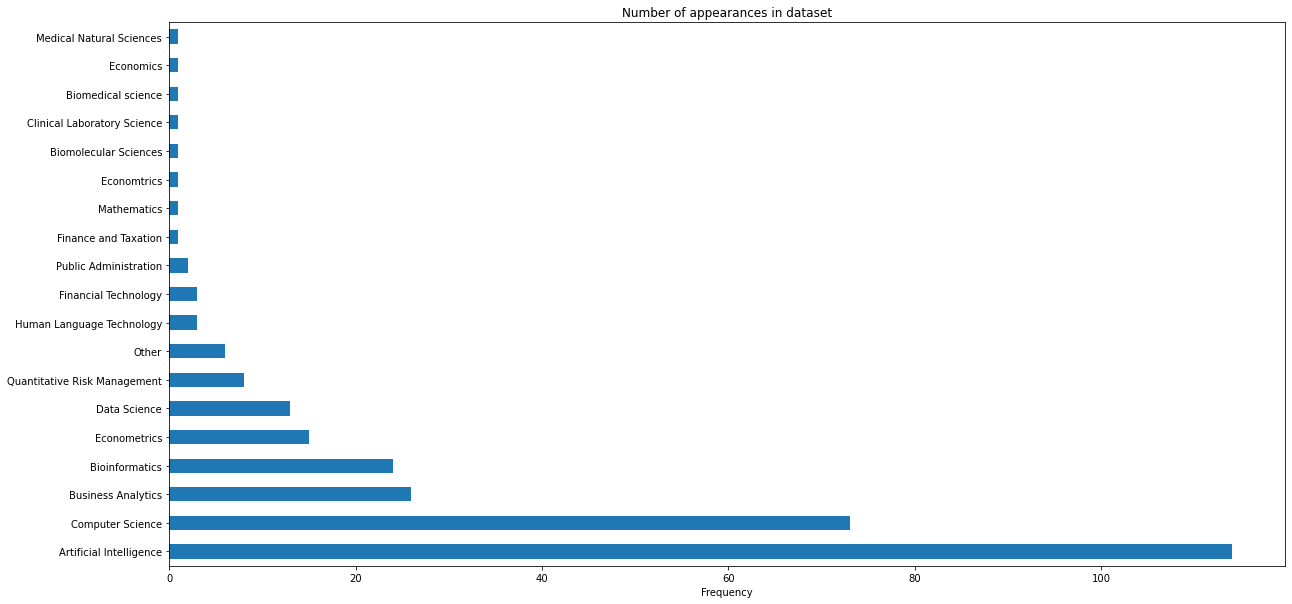

In [5]:
"""Filtering column 1: 'What programme are you in?' and returning bar chart and a Pie chart"""

# Change as much as possible using the .contains
df.loc[df['What programme are you in?'].str.contains('artificial intelligence', case=False), 'What programme are you in?'] = 'Artificial Intelligence'
df.loc[df['What programme are you in?'].str.contains('Ai', case=True), 'What programme are you in?'] = 'Artificial Intelligence'
df.loc[df['What programme are you in?'].str.contains('data|IS:DS', case=False), 'What programme are you in?'] = 'Data Science'
df.loc[df['What programme are you in?'].str.contains('comput', case=False), 'What programme are you in?'] = 'Computer Science'
df.loc[df['What programme are you in?'].str.contains('business', case=False), 'What programme are you in?'] = 'Business Analytics'
df.loc[df['What programme are you in?'].str.contains('BA', case=True), 'What programme are you in?'] = 'Business Analytics'
df.loc[df['What programme are you in?'].str.contains('bioinformatics', case=False), 'What programme are you in?'] = 'Bioinformatics'
df.loc[df['What programme are you in?'].str.contains('BISB', case=True), 'What programme are you in?'] = 'Bioinformatics'
df.loc[df['What programme are you in?'].str.contains('biology', case=False), 'What programme are you in?'] = 'Bioinformatics'
df.loc[df['What programme are you in?'].str.contains('fintech|finance', case=False), 'What programme are you in?'] = 'Financial Technology'
df.loc[df['What programme are you in?'].str.contains('econometrics', case=False), 'What programme are you in?'] = 'Econometrics'
df.loc[df['What programme are you in?'].str.contains('EOR|E&OR', case=True), 'What programme are you in?'] = 'Econometrics'
df.loc[df['What programme are you in?'].str.contains('mathematics', case=False), 'What programme are you in?'] = 'Mathematics'
df.loc[df['What programme are you in?'].str.contains('ai', case=True), 'What programme are you in?'] = 'Artificial Intelligence'
df.loc[df['What programme are you in?'].str.contains('AI', case=True), 'What programme are you in?'] = 'Artificial Intelligence'
df.loc[df['What programme are you in?'].str.contains('CS|SEG', case=True), 'What programme are you in?'] = 'Computer Science'
df.loc[df['What programme are you in?'].str.contains('management|QRM', case=False), 'What programme are you in?'] = 'Quantitative Risk Management'
df.loc[df['What programme are you in?'].str.contains('MPA', case=True), 'What programme are you in?'] = 'Public Administration' # MPA - public administration masters
df.loc[df['What programme are you in?'].str.contains('PDCS', case=True), 'What programme are you in?'] = 'Computer Security' # PDCS - Computer security masters
df.loc[df['What programme are you in?'].str.contains('F&T', case=True), 'What programme are you in?'] = 'Finance and Taxation' # F&T - Finance and Taxation masters
df.loc[df['What programme are you in?'].str.contains('CLS', case=True), 'What programme are you in?'] = 'Clinical Laboratory Science' # CLS - Clinical Laboratory Science

# applying 'nan' but in string form to avoid boolean mask errors between ints and strings
df.loc[df['What programme are you in?'].str.contains('programme?', case=True), 'What programme are you in?'] = 'ZAK' # Leaving this as nan string for now to avoid error
df.loc[df['What programme are you in?'].str.contains('chrome', case=True), 'What programme are you in?'] = 'ZAK' # Leaving this as nan string for now to avoid error
df.loc[df['What programme are you in?'].str.contains('None', case=True), 'What programme are you in?'] = 'ZAK' # Leaving this as nan string for now to avoid error
df.loc[df['What programme are you in?'].str.contains('Cheese', case=True), 'What programme are you in?'] = 'ZAK' # Leaving this as nan string for now to avoid error
df.loc[df['What programme are you in?'].str.contains('advanced', case=True), 'What programme are you in?'] = 'Other' # Leaving this as nan string for now to avoid error
df.loc[df['What programme are you in?'].str.contains('PhD', case=True), 'What programme are you in?'] = 'Other' # Leaving this as nan string for now to avoid error
df.loc[df['What programme are you in?'].str.contains('TU', case=True), 'What programme are you in?'] = 'Other' # Leaving this as nan string for now to avoid error
df.loc[df['What programme are you in?'].str.contains('Exchange', case=True), 'What programme are you in?'] = 'Other' # Leaving this as nan string for now to avoid error
df.loc[df['What programme are you in?'].str.contains('Python', case=True), 'What programme are you in?'] = 'Other' # Leaving this as nan string for now to avoid error

# Change lowercase 'cs' to Computer Science
df['What programme are you in?'] = df['What programme are you in?'].apply(lambda i: i if len(i) > 2 else 'ZAK')

# Replace 'E' by checking length of string to avoid clashes with other strings such as 'Econometrics'
df['What programme are you in?'] = df['What programme are you in?'].apply(lambda i: i if len(i) > 1 else 'ZAK')

# Change strings of 'ZAK' to np.NaN
df['What programme are you in?'] = df['What programme are you in?'].replace('ZAK', np.nan)

# value count the strings to plot them in bar chart
df['What programme are you in?'].value_counts().plot(kind='barh', figsize=(20, 10))
plt.title('Number of appearances in dataset')
plt.xlabel('Frequency')

# Make list of the first column for reference
# mark_list = df['What programme are you in?'].tolist()
# print(mark_list)



Text(0.5, 1.0, 'Number of appearances in dataset')

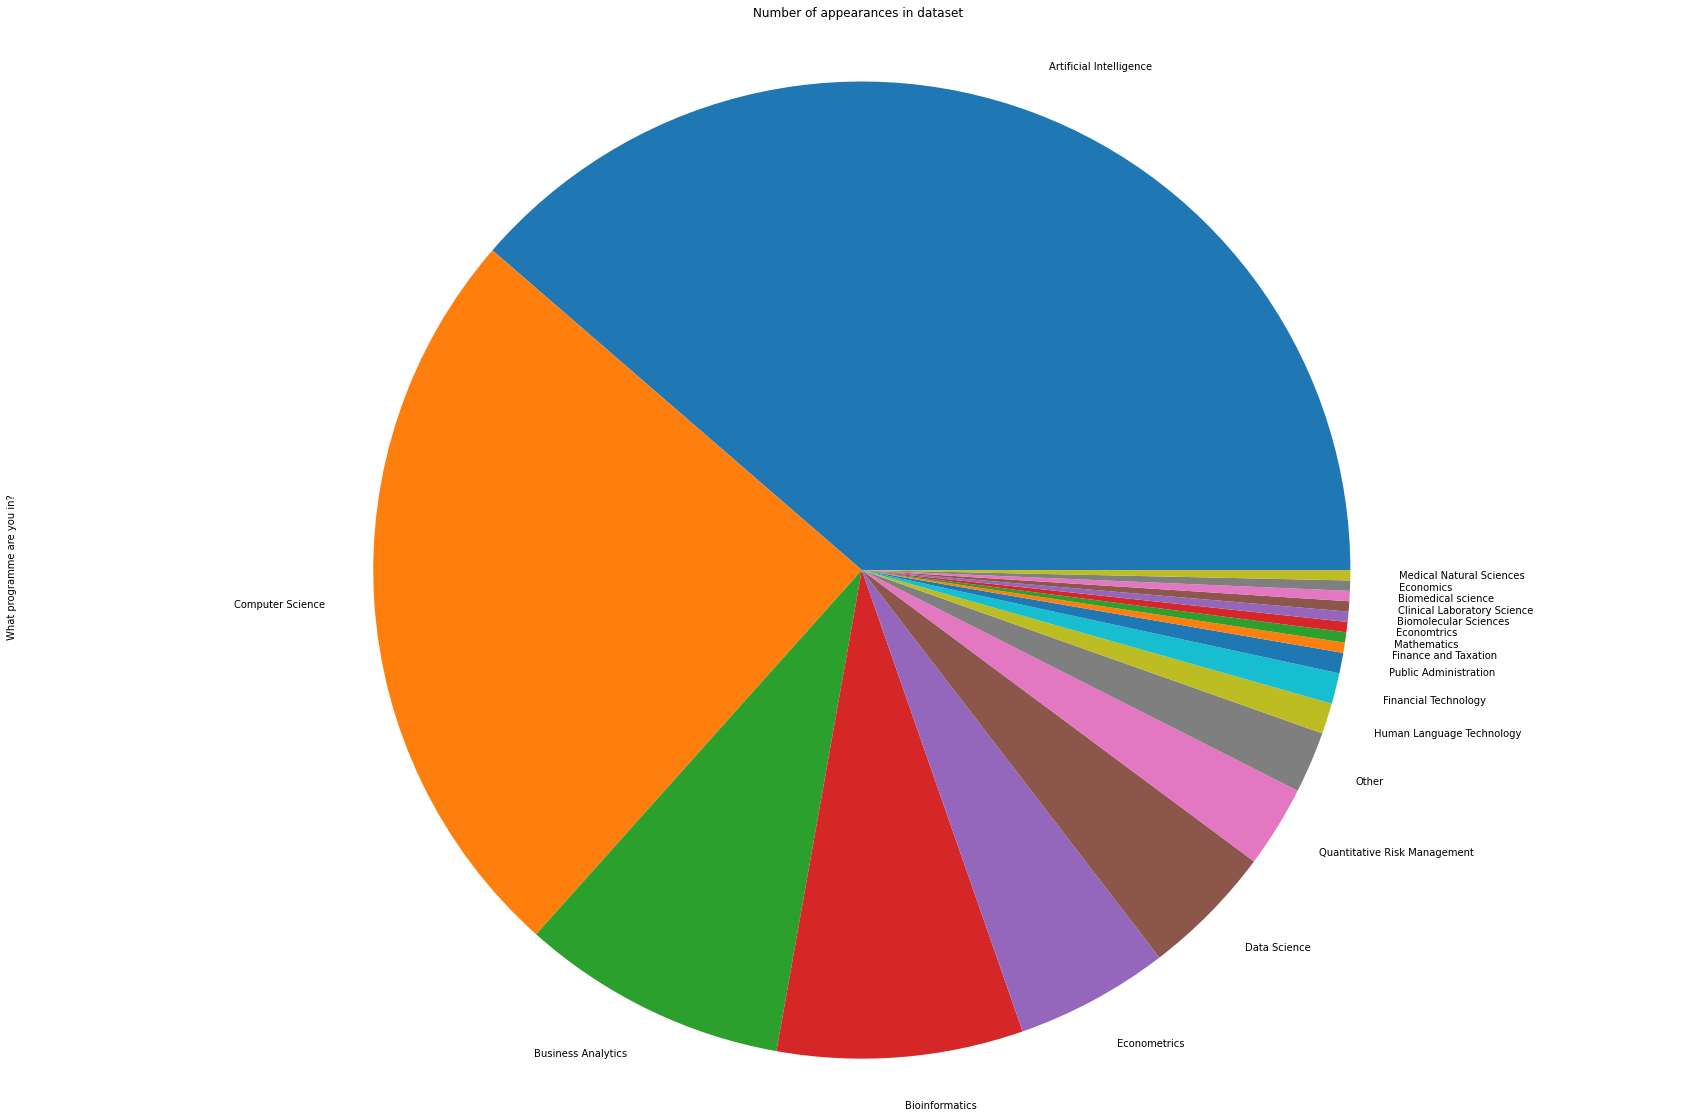

In [6]:
# Value count them make a pie chart
df['What programme are you in?'].value_counts().plot(kind='pie', figsize= (30, 20))
plt.axis('equal')
plt.title('Number of appearances in dataset')

In [7]:
# How many records are there
n_records = df.shape[0]
print(f"There are {n_records} records in the file.")

# How many attributes?
n_attributes = len(df.columns)
print(f"There are {n_attributes} attributes in the file.")

# Make various plots of the data. Is there something interesting worth reporting? Re-
# port the figures, discuss what is in them. What meaning do those bars, lines, dots, etc.
# convey? Please select essential and interesting plots for discussion, as you have limited
# space for reporting your findings (see details in a later section).

There are 302 records in the file.
There are 13 attributes in the file.
